# Configs and Imports

In [1]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.base import clone
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
N_FOLDS = 10
N_REPEATS = 5
SEED = 27

# Loading and Processing The Datasets

In [3]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv', index_col='id')

train.shape, test.shape

((7340, 17), (397, 7))

In [4]:
missing_cols_in_test = [
    'shutdown',
    'mini_shutdown',
    'blackout',
    'mov_change',
    'frankfurt_shutdown',
    'precipitation',
    'snow',
    'user_activity_1',
    'user_activity_2'
]

train = train.drop(missing_cols_in_test, axis=1, errors='ignore')
train.shape, test.shape

((7340, 8), (397, 7))

In [5]:
train

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
id,,,,,,,,
Prague_1_2020-12-05,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0
Prague_1_2020-12-06,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0
Prague_1_2020-12-07,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0
Prague_1_2020-12-08,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0
Prague_1_2020-12-09,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...
Budapest_1_2024-03-10,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0
Budapest_1_2024-03-11,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0
Budapest_1_2024-03-12,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0


In [6]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
id,,,,,,,
Prague_1_2024-03-16,Prague_1,2024-03-16,NaN,0,0,0,0
Prague_1_2024-03-17,Prague_1,2024-03-17,NaN,0,0,0,0
Prague_1_2024-03-18,Prague_1,2024-03-18,NaN,0,0,0,0
Prague_1_2024-03-19,Prague_1,2024-03-19,NaN,0,0,0,0
Prague_1_2024-03-20,Prague_1,2024-03-20,NaN,0,0,0,0
...,...,...,...,...,...,...,...
Budapest_1_2024-05-11,Budapest_1,2024-05-11,NaN,0,0,0,0
Budapest_1_2024-05-12,Budapest_1,2024-05-12,NaN,0,0,0,0
Budapest_1_2024-05-13,Budapest_1,2024-05-13,NaN,0,0,0,0


In [7]:
for df in [train, test]:
    df['holiday_name'] = df['holiday_name'].fillna('').astype('category')
    df['warehouse'] = df['warehouse'].astype('category')
    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['season'] = (df['month'] % 12 + 3) // 3
    df['season'] = df['season'].astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['day_before_holiday'] = df['holiday'].shift().fillna(0)
    df['day_after_holiday'] = df['holiday'].shift(-1).fillna(0)
    df['day_before_school_holiday'] = df['school_holidays'].shift().fillna(0)
    df['day_after_school_holiday'] = df['school_holidays'].shift(-1).fillna(0)
    df['day_before_winter_school_holiday'] = df['winter_school_holidays'].shift().fillna(0)
    df['day_after_winter_school_holiday'] = df['winter_school_holidays'].shift(-1).fillna(0)
    df['holiday_and_shops_closed'] = df['holiday'] * df['shops_closed']
    df['week_before_holiday'] = df['holiday'].shift(-7).rolling(window=7, min_periods=1).sum().shift(1).fillna(0).apply(lambda x: 1 if x > 0 else 0)

cat_features = [col for col in train.columns if train[col].dtype.name == 'category']

train.shape, test.shape

((7340, 25), (397, 24))

In [8]:
train

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,...,season,is_weekend,day_before_holiday,day_after_holiday,day_before_school_holiday,day_after_school_holiday,day_before_winter_school_holiday,day_after_winter_school_holiday,holiday_and_shops_closed,week_before_holiday
id,,,,,,,,,,,,,,,,,,,,,
Prague_1_2020-12-05,Prague_1,2020-12-05,6895.0,,0,0,0,0,2020,12,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2020-12-06,Prague_1,2020-12-06,6584.0,,0,0,0,0,2020,12,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2020-12-07,Prague_1,2020-12-07,7030.0,,0,0,0,0,2020,12,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2020-12-08,Prague_1,2020-12-08,6550.0,,0,0,0,0,2020,12,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2020-12-09,Prague_1,2020-12-09,6910.0,,0,0,0,0,2020,12,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Budapest_1_2024-03-10,Budapest_1,2024-03-10,6733.0,,0,0,0,0,2024,3,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Budapest_1_2024-03-11,Budapest_1,2024-03-11,6492.0,,0,0,0,0,2024,3,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Budapest_1_2024-03-12,Budapest_1,2024-03-12,6661.0,,0,0,0,0,2024,3,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [9]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,...,season,is_weekend,day_before_holiday,day_after_holiday,day_before_school_holiday,day_after_school_holiday,day_before_winter_school_holiday,day_after_winter_school_holiday,holiday_and_shops_closed,week_before_holiday
id,,,,,,,,,,,,,,,,,,,,,
Prague_1_2024-03-16,Prague_1,2024-03-16,,0,0,0,0,2024,3,16,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2024-03-17,Prague_1,2024-03-17,,0,0,0,0,2024,3,17,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2024-03-18,Prague_1,2024-03-18,,0,0,0,0,2024,3,18,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2024-03-19,Prague_1,2024-03-19,,0,0,0,0,2024,3,19,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Prague_1_2024-03-20,Prague_1,2024-03-20,,0,0,0,0,2024,3,20,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Budapest_1_2024-05-11,Budapest_1,2024-05-11,,0,0,0,0,2024,5,11,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Budapest_1_2024-05-12,Budapest_1,2024-05-12,,0,0,0,0,2024,5,12,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
Budapest_1_2024-05-13,Budapest_1,2024-05-13,,0,0,0,0,2024,5,13,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [10]:
X_train = train.drop(['date', 'orders'], axis=1)
y_train = train['orders']

X_test = test.drop(['date'], axis=1)

assert X_train.shape[1] == X_test.shape[1]

# Training Base Models

In [11]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS, n_repeats=N_REPEATS):
        self.model = model
        self.n_folds = n_folds
        self.n_repeats = n_repeats

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')
        
        kf = KFold(n_splits=self.n_folds)
        
        scores = []
        oof_preds = np.zeros(len(X), dtype=float)
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = mean_absolute_percentage_error(y_val, y_pred)
            scores.append(score)
            
            print(f'--- Fold {fold_idx + 1} - MAPE: {score:.6f}')
            
            oof_preds[val_idx] = y_pred
            
        print(f'\n------ MAPE: {np.mean(scores):.6f} ± {np.std(scores):.6f}\n\n')
            
        return m, scores, oof_preds
        
    def fit_predict(self, X, y, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(X, y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [12]:
xgb_params = {
    'colsample_bylevel':0.978696066577821,
    'colsample_bynode':0.7172082549359998,
    'colsample_bytree':0.6255308497005857,
    'enable_categorical':True,
    'gamma':0.29765748378440304,
    'grow_policy':"depthwise",
    'max_bin':192,
    'max_delta_step':8.904159240264047,
    'max_depth':22,
    'max_leaves':175,
    'min_child_weight':9.928969766476069,
    'n_estimators':4456,
    'n_jobs':-1,
    'random_state':SEED,
    'reg_alpha':2.069224752430643,
    'reg_lambda':4.074927959568395,
    'subsample':0.08110733959547455,
    'verbosity':0,
}

cb_params = {
    'border_count':174,
    'colsample_bylevel':0.17768073671579976,
    'depth':2,
    'grow_policy':"SymmetricTree",
    'iterations':1949,
    'l2_leaf_reg':6.396958169915129,
    'min_child_samples':100,
    'random_state':SEED,
    'random_strength':0.11618052150854308,
    'thread_count':-1,
    'verbose':False
}

lgbm_params = {
    'colsample_bytree':0.1645770354307945,
    'max_depth':90,
    'min_child_samples':45,
    'min_child_weight':0.2048484917063969,
    'n_estimators':4207,
    'n_jobs':-1,
    'num_leaves':14,
    'random_state':SEED,
    'reg_alpha':0.4727667375812743,
    'reg_lambda':0.5206539876202971,
    'subsample':0.9818223317129048,
    'subsample_freq':8,
    'verbose':-1,
}

In [13]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
xgb_model, xgb_scores, xgb_oof_preds = xgb_trainer.fit(X_train, y_train)
xgb_test_preds = xgb_trainer.fit_predict(X_train, y_train, X_test)

Training XGBRegressor
--- Fold 1 - MAPE: 0.050063
--- Fold 2 - MAPE: 0.045861
--- Fold 3 - MAPE: 0.069326
--- Fold 4 - MAPE: 0.045296
--- Fold 5 - MAPE: 0.060656
--- Fold 6 - MAPE: 0.040162
--- Fold 7 - MAPE: 0.246022
--- Fold 8 - MAPE: 0.196199
--- Fold 9 - MAPE: 0.222256
--- Fold 10 - MAPE: 0.037829

------ MAPE: 0.101367 ± 0.079910




In [14]:
cb_model = CatBoostRegressor(**cb_params, cat_features=cat_features)
cb_trainer = Trainer(cb_model)
cb_model, cb_scores, cb_oof_preds = cb_trainer.fit(X_train, y_train)
cb_test_preds = cb_trainer.fit_predict(X_train, y_train, X_test)

Training CatBoostRegressor
--- Fold 1 - MAPE: 0.061956
--- Fold 2 - MAPE: 0.058348
--- Fold 3 - MAPE: 0.061586
--- Fold 4 - MAPE: 0.108906
--- Fold 5 - MAPE: 0.050432
--- Fold 6 - MAPE: 0.063790
--- Fold 7 - MAPE: 0.201498
--- Fold 8 - MAPE: 0.237893
--- Fold 9 - MAPE: 0.200530
--- Fold 10 - MAPE: 0.045395

------ MAPE: 0.109033 ± 0.070777




In [15]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
lgbm_model, lgbm_scores, lgbm_oof_preds = lgbm_trainer.fit(X_train, y_train)
lgbm_test_preds = lgbm_trainer.fit_predict(X_train, y_train, X_test)

Training LGBMRegressor
--- Fold 1 - MAPE: 0.046343
--- Fold 2 - MAPE: 0.039190
--- Fold 3 - MAPE: 0.035516
--- Fold 4 - MAPE: 0.048158
--- Fold 5 - MAPE: 0.043352
--- Fold 6 - MAPE: 0.033207
--- Fold 7 - MAPE: 0.208742
--- Fold 8 - MAPE: 0.205718
--- Fold 9 - MAPE: 0.167712
--- Fold 10 - MAPE: 0.042946

------ MAPE: 0.087088 ± 0.070899




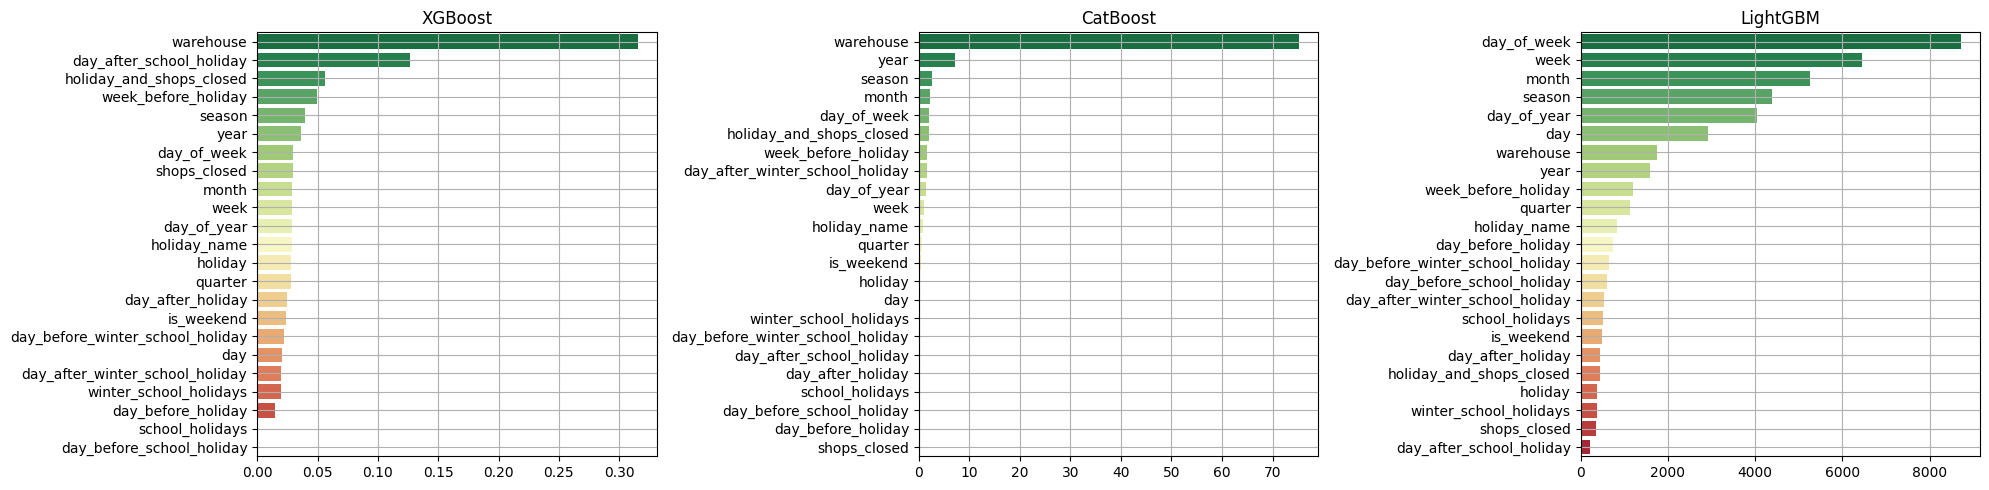

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

palette = sns.color_palette("RdYlGn_r", len(X_train.columns))

xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=xgb_importances.index, x=xgb_importances.values, orient='h', ax=axs[0], palette=palette)
axs[0].set_title('XGBoost')
axs[0].grid(True)

cb_importances = pd.Series(cb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=cb_importances.index, x=cb_importances.values, orient='h', ax=axs[1], palette=palette)
axs[1].set_title('CatBoost')
axs[1].grid(True)

lgbm_importances = pd.Series(lgbm_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=lgbm_importances.index, x=lgbm_importances.values, orient='h', ax=axs[2], palette=palette)
axs[2].set_title('LightGBM')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Ensemble

In [17]:
_X_train = pd.DataFrame(np.column_stack([
    xgb_oof_preds,
    cb_oof_preds, 
    lgbm_oof_preds
]))

_X_test = pd.DataFrame(np.column_stack([
    xgb_test_preds,
    cb_test_preds,
    lgbm_test_preds
]))

In [18]:
ridge_model = Ridge()
ridge_trainer = Trainer(ridge_model, n_repeats=1)
ridge_model, ridge_scores, ridge_oof_preds = ridge_trainer.fit(_X_train, y_train)
ridge_test_preds = ridge_trainer.fit_predict(_X_train, y_train, _X_test)

Training Ridge
--- Fold 1 - MAPE: 0.048158
--- Fold 2 - MAPE: 0.043287
--- Fold 3 - MAPE: 0.046510
--- Fold 4 - MAPE: 0.053117
--- Fold 5 - MAPE: 0.045491
--- Fold 6 - MAPE: 0.032226
--- Fold 7 - MAPE: 0.210345
--- Fold 8 - MAPE: 0.201606
--- Fold 9 - MAPE: 0.194737
--- Fold 10 - MAPE: 0.039013

------ MAPE: 0.091449 ± 0.072795




In [19]:
lasso_model = Lasso()
lasso_trainer = Trainer(lasso_model, n_repeats=1)
lasso_model, lasso_scores, lasso_oof_preds = lasso_trainer.fit(_X_train, y_train)
lasso_test_preds = lasso_trainer.fit_predict(_X_train, y_train, _X_test)

Training Lasso
--- Fold 1 - MAPE: 0.048158
--- Fold 2 - MAPE: 0.043287
--- Fold 3 - MAPE: 0.046510
--- Fold 4 - MAPE: 0.053116
--- Fold 5 - MAPE: 0.045491
--- Fold 6 - MAPE: 0.032226
--- Fold 7 - MAPE: 0.210345
--- Fold 8 - MAPE: 0.201607
--- Fold 9 - MAPE: 0.194737
--- Fold 10 - MAPE: 0.039013

------ MAPE: 0.091449 ± 0.072795




In [20]:
ridge_cv_model = RidgeCV()
ridge_cv_trainer = Trainer(ridge_cv_model, n_repeats=1)
ridge_cv_model, ridge_cv_scores, ridge_cv_oof_preds = ridge_cv_trainer.fit(_X_train, y_train)
ridge_cv_test_preds = ridge_cv_trainer.fit_predict(_X_train, y_train, _X_test)

Training RidgeCV
--- Fold 1 - MAPE: 0.048157
--- Fold 2 - MAPE: 0.043288
--- Fold 3 - MAPE: 0.046511
--- Fold 4 - MAPE: 0.053117
--- Fold 5 - MAPE: 0.045491
--- Fold 6 - MAPE: 0.032227
--- Fold 7 - MAPE: 0.210346
--- Fold 8 - MAPE: 0.201606
--- Fold 9 - MAPE: 0.194744
--- Fold 10 - MAPE: 0.039013

------ MAPE: 0.091450 ± 0.072796




In [21]:
lasso_cv_model = LassoCV()
lasso_cv_trainer = Trainer(lasso_cv_model, n_repeats=1)
lasso_cv_model, lasso_cv_scores, lasso_cv_oof_preds = lasso_cv_trainer.fit(_X_train, y_train)
lasso_cv_test_preds = lasso_cv_trainer.fit_predict(_X_train, y_train, _X_test)

Training LassoCV
--- Fold 1 - MAPE: 0.045146
--- Fold 2 - MAPE: 0.047432
--- Fold 3 - MAPE: 0.041887
--- Fold 4 - MAPE: 0.051114
--- Fold 5 - MAPE: 0.044795
--- Fold 6 - MAPE: 0.033911
--- Fold 7 - MAPE: 0.210934
--- Fold 8 - MAPE: 0.200346
--- Fold 9 - MAPE: 0.195444
--- Fold 10 - MAPE: 0.038999

------ MAPE: 0.091001 ± 0.073042




# Visualizing The Results

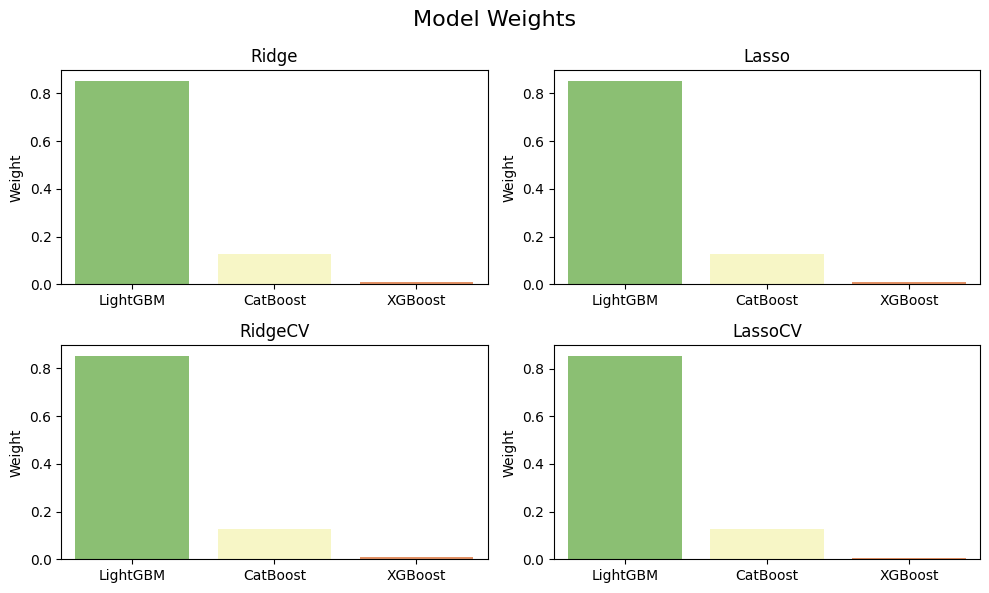

In [22]:
models = [ridge_model, lasso_model, ridge_cv_model, lasso_cv_model]
model_names = [
    'XGBoost',
    'CatBoost',
    'LightGBM',
]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, model in zip(axes.flatten(), models):
    weights = pd.Series(model.coef_, index=model_names).sort_values(ascending=False)
    sns.barplot(x=weights.index, y=weights.values, ax=ax, palette='RdYlGn_r')
    ax.set_title(f'{model.__class__.__name__}')
    ax.set_ylabel('Weight')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

fig.suptitle('Model Weights', fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    cb_model.__class__.__name__: cb_scores,
    ridge_model.__class__.__name__: ridge_scores,
    ridge_cv_model.__class__.__name__: ridge_cv_scores,
    lasso_model.__class__.__name__: lasso_scores,
    lasso_cv_model.__class__.__name__: lasso_cv_scores
})

mean_scores = scores.mean().sort_values(ascending=False)
x_min = mean_scores.min() - 0.05 * mean_scores.min()
x_max = mean_scores.max() + 0.05 * mean_scores.max()

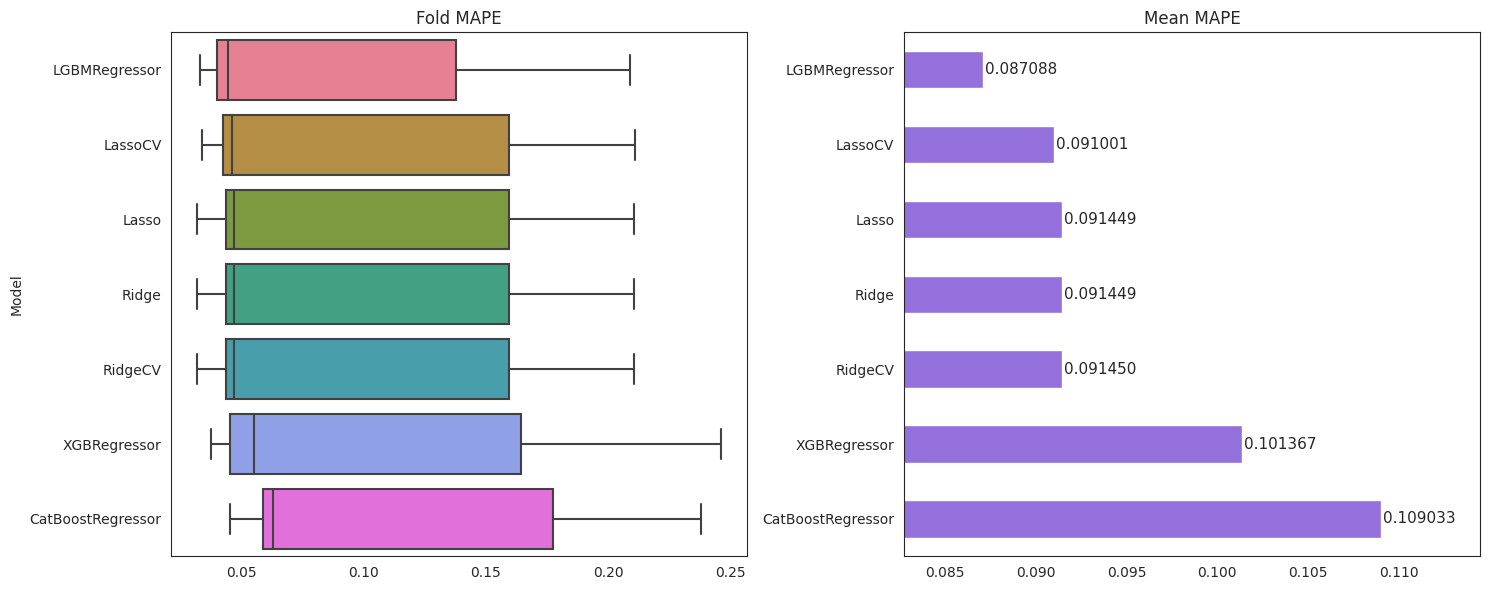

In [24]:
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=scores, orient='h', palette='husl', ax=axes[0], order=scores.mean().sort_values().index.tolist())
axes[0].set_title('Fold MAPE')
axes[0].set_xlabel('')
axes[0].set_ylabel('Model')

mean_scores = scores.mean().sort_values(ascending=False)
mean_scores.plot(kind='barh', ax=axes[1], color='#9370DB')
axes[1].set_title('Mean MAPE')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim([x_min, x_max])

for i, v in enumerate(mean_scores):
    axes[1].text(v + 1e-4, i, f'{v:.6f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

In [25]:
submission = pd.DataFrame({'id': test.index, 'orders': lasso_cv_test_preds})
submission.to_csv(f'lassocv-mape_{np.mean(lasso_cv_scores)}.csv', index=False)

In [26]:
submission = submission.rename(columns={'id': 'warehouse'})
submission['date'] = submission['warehouse'].str.split('_').str[2]
submission['warehouse'] = submission['warehouse'].str.split('_').str[:2].str.join('_')

submission['date'] = pd.to_datetime(submission['date'], errors='coerce')
warehouses = submission['warehouse'].unique()
n_warehouses = len(warehouses)

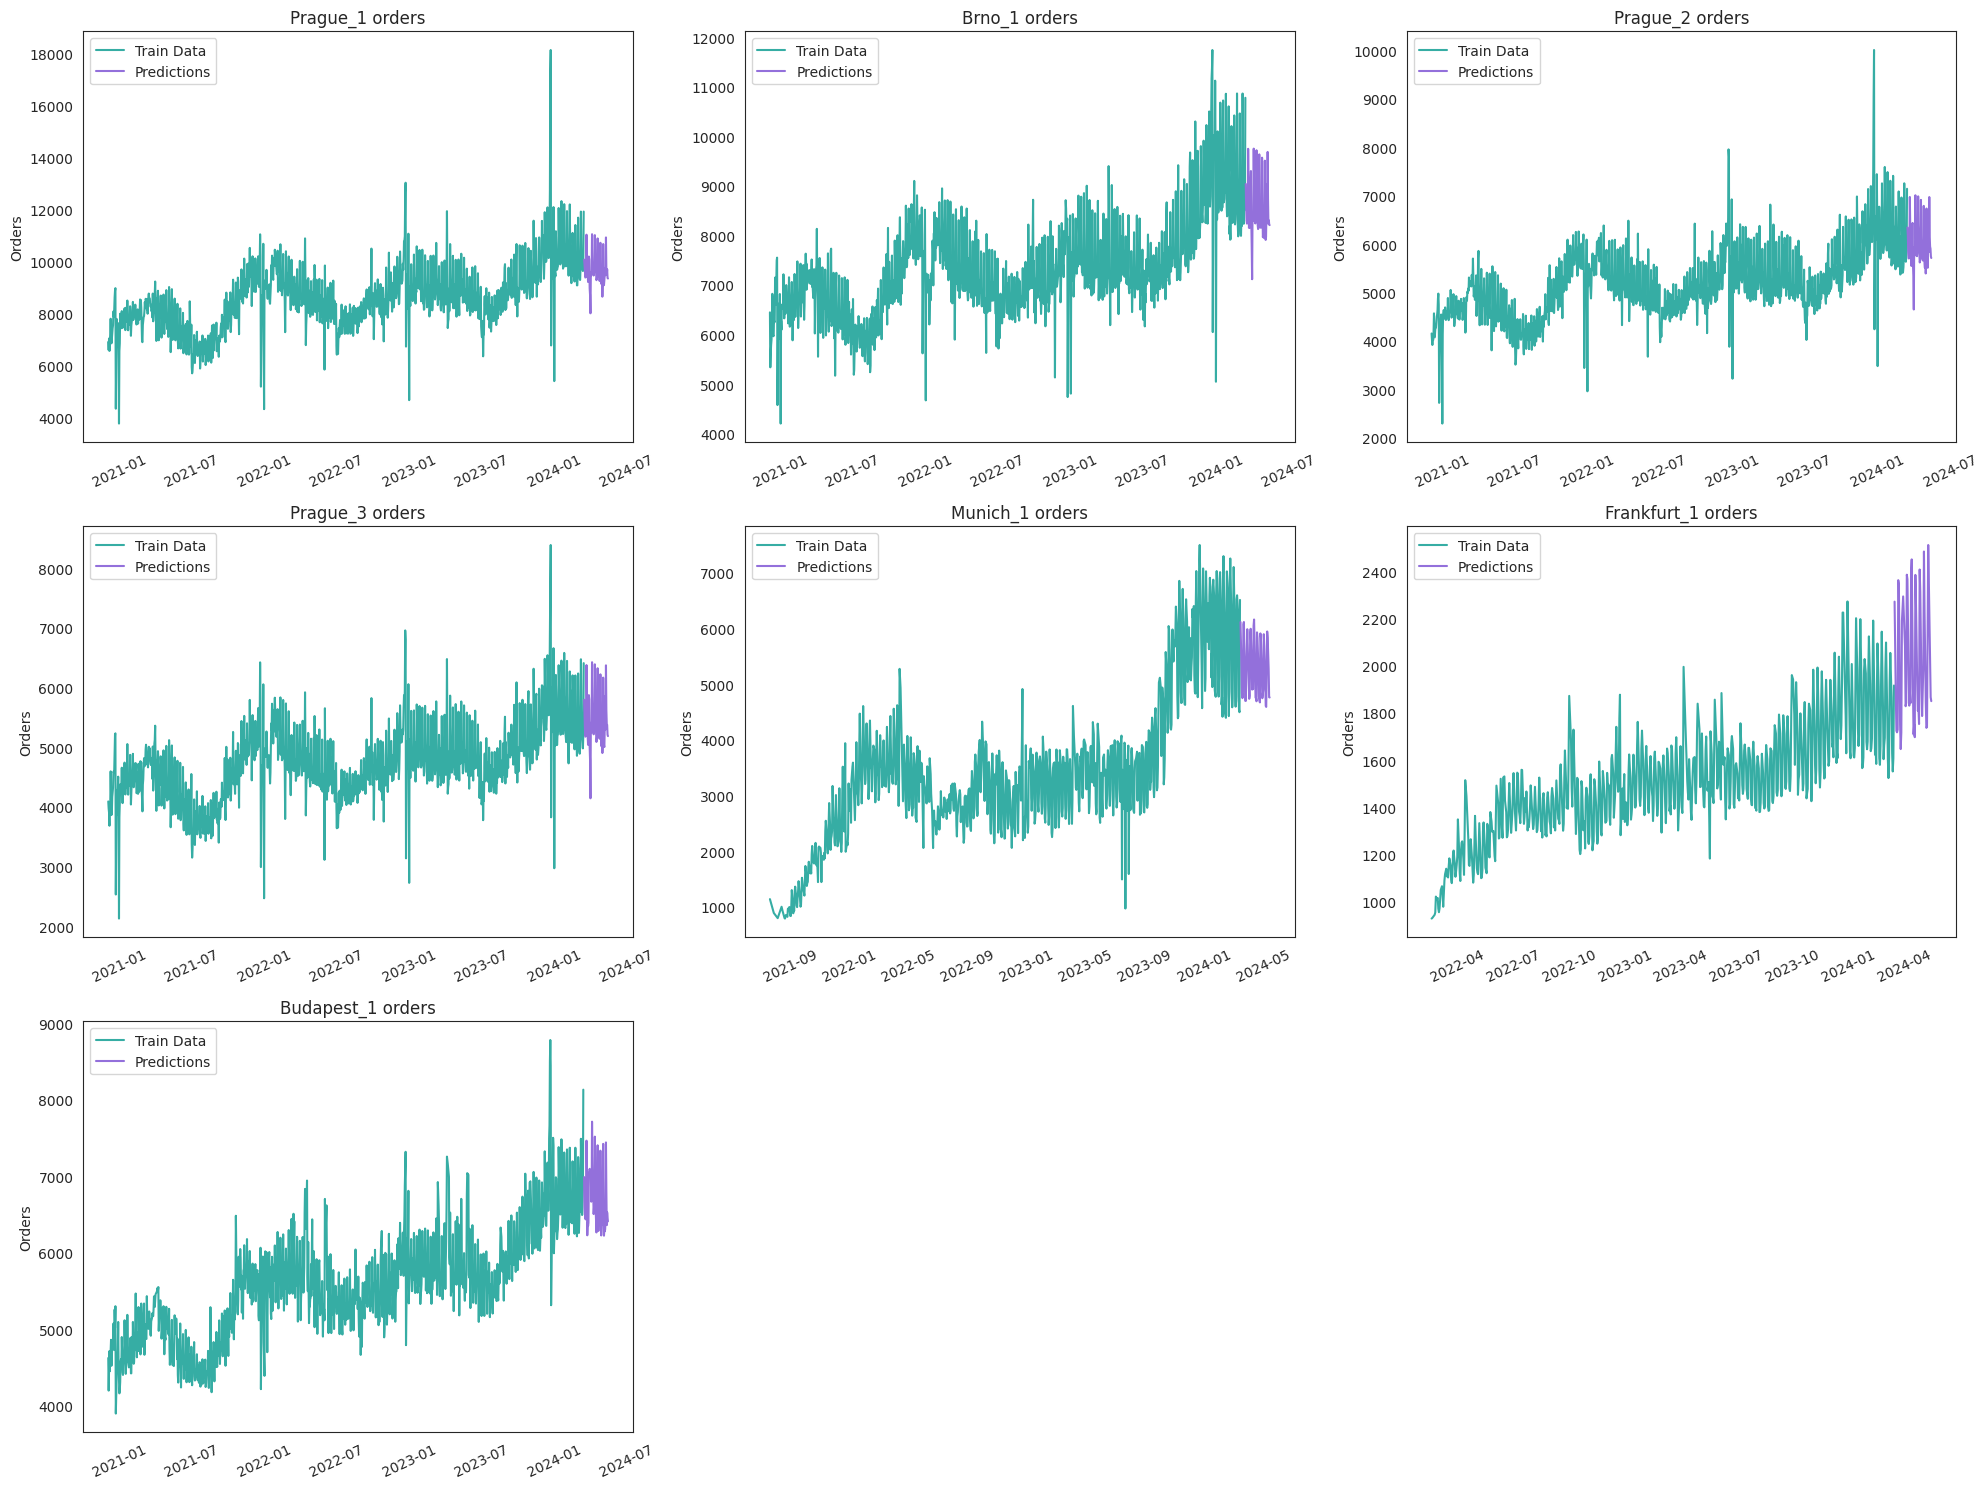

In [27]:
# This plot is based on https://www.kaggle.com/competitions/rohlik-orders-forecasting-challenge/discussion/511783
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for ax, wh in zip(axes.flatten(), warehouses):
    wh_train = train[train['warehouse'] == wh][['warehouse', 'orders', 'date']].set_index('date')
    wh_submission = submission[submission['warehouse'] == wh][['warehouse', 'orders', 'date']].set_index('date')

    sns.lineplot(x=wh_train.index, y=wh_train['orders'], label='Train Data', ax=ax, color=sns.color_palette('husl')[3])
    sns.lineplot(x=wh_submission.index, y=wh_submission['orders'], label='Predictions', ax=ax, color='#9370DB')

    ax.set_title(f'{wh} orders')
    ax.set_xlabel('')
    ax.set_ylabel('Orders')
    ax.legend()
    ax.tick_params(axis='x', rotation=25)

axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

plt.tight_layout()
plt.show()